# practice lesson 9-10

- https://wandb.ai/site

- https://www.tensorflow.org/tensorboard

In [1]:
# !pip install wandb
# poetry add wandb
## = instruments for visualizations
# !pip install tensorboard
# poetry add tensorboard

In [18]:
import os
import math
import random

import cv2  # poetry add opencv-python
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import losses
from keras import metrics
from keras import optimizers

import wandb
from wandb.keras import WandbMetricsLogger

Clean last tensorboard logs:

In [33]:
!rm -rf ./logs/

- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [35]:
from tensorflow.keras.callbacks import TensorBoard

In [36]:
model_name = 'model_opt_lr=__...'
log_folder = 'logs/fit/' + model_name
tensorboard_callback = TensorBoard(log_dir = log_folder)

In [48]:
# num_classes = 10
# num_features = 32 * 32

lr = 0.1
n_epochs = 10
batch_size = 256

- https://wandb.ai/site
! enter wandb token:

In [49]:
wandb.init(project='2023-08-06_test_1', config={'lr': lr, 'n_epochs': n_epochs, 'batch_size': batch_size})

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/accuracy,▄▄▆█▇▁▄▄▆█▇▁
epoch/epoch,▁▂▄▅▇█▁▂▄▅▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁█▁▁▁▁▁
epoch/val_accuracy,▅▇▆█▁▁▅▇▆█▁▁
epoch/val_loss,▆▄▃▂█▁▆▄▃▂█▁
epoch/accuracy,0.49448
epoch/epoch,5
epoch/learning_rate,0.1
epoch/loss,1.49278
epoch/val_accuracy,0.50016


In [50]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(42)

In [51]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [52]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [42]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, X, y, shuffle=True, batch_size=256):
        self.X = X
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.batch_size = batch_size
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.X) / self.batch_size)
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_X_row = [self.X[i] for i in indexes]
        batch_y = [self.y[i] for i in indexes]
        
        batch_X = []
        for i in range(min(self.batch_size, len(indexes))):
            new_vector = [0] * 10000
            for elem in batch_X_row[i]:
                new_vector[elem] = 1
            batch_X.append(new_vector)
        
        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [43]:
train_dataset = Dataset(train_data, train_labels, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(test_data, test_labels, shuffle=False, batch_size=batch_size)

len(train_dataset)

98

Використання оптимізатора Lion

- https://hasty.ai/docs/mp-wiki/solvers-optimizers/lion

In [59]:
from tensorflow.keras.regularizers import L2

In [61]:
model = Sequential(
                   [
                    Dense(1024, activation='relu', input_shape=(10000,), kernel_regularizer=L2(l2=0.005), name = 'hidden_1'),
                    Dense(1024, activation='relu', kernel_regularizer=L2(l2=0.005), name = 'hidden_2'),
                    Dense(1024, activation='relu', kernel_regularizer=L2(l2=0.005), name = 'hidden_3'),
                    Dense(1, activation='sigmoid', name = 'output'),
                    ],
                    name = 'ny_model_5'
                    )

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Lion

In [65]:
optimizer_lion = optimizers.Lion(learning_rate=lr)  # Lion()

In [66]:
model.compile(
              optimizer=optimizer_lion,  # optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

In [67]:
callback_early_stopping = EarlyStopping(
                                        monitor='val_accuracy',
                                        patience=2,
                                        verbose=1,
                                        mode='max',
                                        )

callback_save = ModelCheckpoint(
                                'best.hdf5',
                                monitor='val_loss',
                                save_best_only=True,
                                )

In [68]:
history = model.fit(
                    train_dataset,
                    # validation_split=0.2, # 20% from train_dataset for validation
                    validation_data=valid_dataset,
                    epochs=n_epochs,
                    verbose=1,
                    callbacks=[callback_early_stopping, WandbMetricsLogger(), tensorboard_callback]
                    )

Epoch 1/10
98/98 [==============================] - 32s 322ms/step - loss: 56784.8203 - accuracy: 0.5036 - val_loss: 97203.1719 - val_accuracy: 0.4982
Epoch 2/10
98/98 [==============================] - 30s 309ms/step - loss: 144022.4531 - accuracy: 0.5134 - val_loss: 143080.2969 - val_accuracy: 0.5051
Epoch 3/10
98/98 [==============================] - 30s 308ms/step - loss: 208664.9062 - accuracy: 0.5305 - val_loss: 218078.7188 - val_accuracy: 0.5564
Epoch 4/10
98/98 [==============================] - 30s 309ms/step - loss: 295531.7188 - accuracy: 0.7167 - val_loss: 273061.0312 - val_accuracy: 0.8428
Epoch 5/10
98/98 [==============================] - 29s 299ms/step - loss: 434370.0625 - accuracy: 0.7838 - val_loss: 467200.9688 - val_accuracy: 0.7419
Epoch 6/10
98/98 [==============================] - 29s 296ms/step - loss: 552500.7500 - accuracy: 0.6921 - val_loss: 747407.6875 - val_accuracy: 0.5022
Epoch 6: early stopping


In [53]:
%load_ext tensorboard

In [54]:
%tensorboard --logdir logs

- https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights

In [ ]:
model.save_weights('my_model.hdf5')

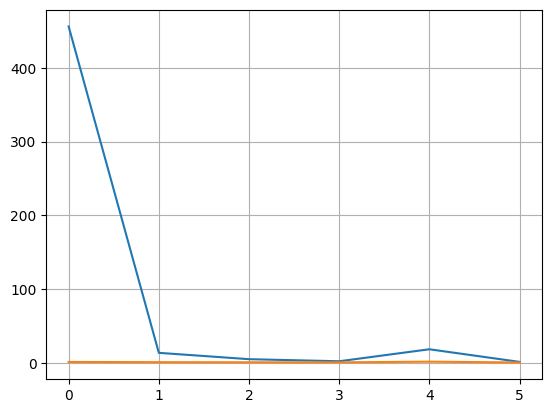

In [30]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()

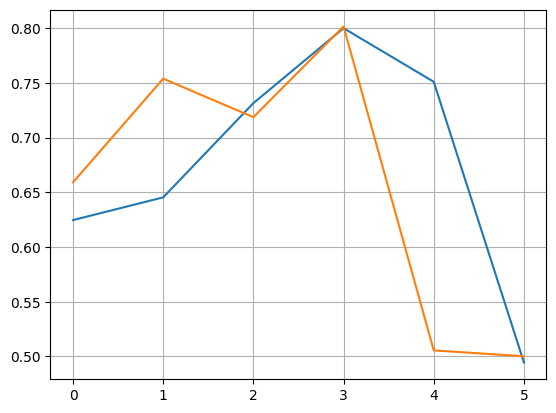

In [31]:
plt.plot(history.history['accuracy'], label='train loss')
plt.plot(history.history['val_accuracy'], label='valid loss')
plt.grid()

In [32]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]])
tmp = [word_index.get(word, -2) + 3 for word in decoded_review.split(" ")]
new_vector = [0] * 10000

for elem in tmp:
    new_vector[elem] = 1

new_vector = np.array(new_vector).reshape(1, 10000)
model.predict(new_vector)

1/1 [==============================] - 0s 71ms/step


array([[0.49608222]], dtype=float32)

In [ ]:
wandb.finish()